In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    make_scorer,
    mean_squared_log_error,
)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score

In [10]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [11]:
def process_data(data_df):
    data_df = data_df[
        [
            "budget",
            "popularity",
            "runtime",
            "vote_average",
            "vote_count",
            "release_date",
            "revenue",
        ]
    ]
    data_df["release_date"] = pd.to_datetime(data_df["release_date"])
    data_df["release_year"] = data_df["release_date"].dt.year
    data_df = data_df.drop(columns=["release_date"])

    return data_df

In [12]:
train = process_data(train)
test = process_data(test)

C:\Users\lemuelkl\AppData\Local\Temp\ipykernel_25584\2011059654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df["release_date"] = pd.to_datetime(data_df["release_date"])
C:\Users\lemuelkl\AppData\Local\Temp\ipykernel_25584\2011059654.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df["release_year"] = data_df["release_date"].dt.year
C:\Users\lemuelkl\AppData\Local\Temp\ipykernel_25584\2011059654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [13]:
pipeline = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(
        max_depth=10,
        # min_samples_leaf=5,
        # min_samples_split=5,
        # n_estimators=10,
    ),
)
pipeline.fit(train.drop(columns=["revenue"]), train["revenue"])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor', RandomForestRegressor(max_depth=10))])

In [14]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))


rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

print("R2:", pipeline.score(train.drop(columns=["revenue"]), train["revenue"]))
print(
    "RMSLE:", rmsle_scorer(pipeline, train.drop(columns=["revenue"]), train["revenue"])
)

print("R2:", pipeline.score(test.drop(columns=["revenue"]), test["revenue"]))
print("RMSLE:", rmsle_scorer(pipeline, test.drop(columns=["revenue"]), test["revenue"]))

R2: 0.9440395388465659
RMSLE: -2.2198776880275806
R2: 0.7556196308744267
RMSLE: -2.3825441294269356


In [15]:
# Rank movie predictions by error
test["predicted"] = pipeline.predict(test.drop(columns=["revenue"]))
# Compute error as absolute difference between predicted and actual revenue over actual revenue
test["error"] = np.abs(test["predicted"] - test["revenue"]) / test["revenue"]
test["error_rank"] = test["error"].rank(ascending=False)
test.sort_values("error_rank", inplace=True)
test.head(10)

,budget,popularity,runtime,vote_average,vote_count,revenue,release_year,predicted,error,error_rank
2980,0.0,19.853,119.0,6.200,138.0,0.0,1991,8.033573e+06,inf,20.5
3511,0.0,6.778,111.0,6.300,83.0,0.0,2004,1.183666e+06,inf,20.5
450,0.0,5.895,85.0,6.961,64.0,0.0,2013,5.942525e+05,inf,20.5
1698,0.0,5.641,100.0,4.900,54.0,0.0,1992,2.605960e+06,inf,20.5
2955,0.0,9.840,104.0,7.000,866.0,0.0,2012,6.329263e+06,inf,20.5
453,0.0,7.297,114.0,5.700,24.0,0.0,2014,6.303141e+05,inf,20.5
3567,1500000.0,24.746,148.0,8.000,607.0,0.0,2004,1.583210e+07,inf,20.5
1305,0.0,8.716,90.0,5.400,30.0,0.0,1996,9.975222e+05,inf,20.5
3609,0.0,5.615,110.0,6.900,54.0,0.0,2005,9.176187e+05,inf,20.5
4219,10000000.0,10.532,92.0,5.697,38.0,0.0,1997,5.314904e+06,inf,20.5


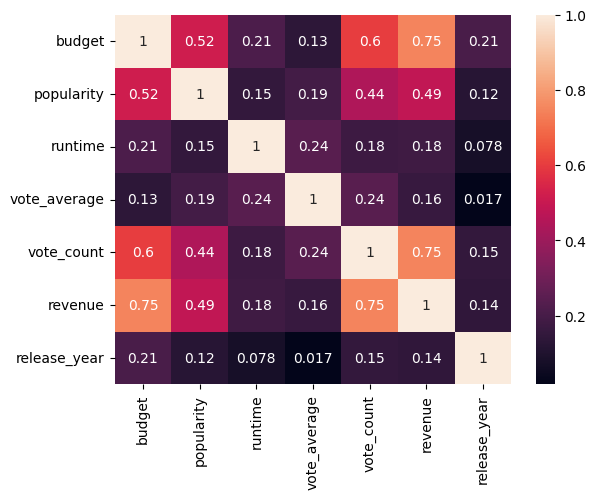

In [16]:
# Print correlation matrix
corr = train.corr()
sns.heatmap(corr, annot=True)
plt.show()

In [17]:
# Print the 10 most important features
feature_importances = pd.DataFrame(
    pipeline.steps[1][1].feature_importances_,
    index=train.drop(columns=["revenue"]).columns,
    columns=["importance"],
).sort_values("importance", ascending=False)
print(feature_importances.head(10))

              importance
vote_count      0.420257
budget          0.397490
popularity      0.070869
runtime         0.039099
vote_average    0.038364
release_year    0.033921


In [18]:
# Make predictions for Kaggle

kaggle_df = pd.read_csv("test.csv")
kaggle_df = kaggle_df[
    [
        "budget",
        "popularity",
        "runtime",
        "vote_average",
        "vote_count",
        "release_date",
        "id_kaggle",
    ]
]
kaggle_df["release_date"] = pd.to_datetime(kaggle_df["release_date"])
kaggle_df["release_year"] = kaggle_df["release_date"].dt.year
# kaggle_df["cpi"] = kaggle_df["release_date"].apply(lambda x: cpi.get(x.year))
kaggle_df = kaggle_df.drop(columns=["release_date"])

kaggle_df["revenue"] = pipeline.predict(
    kaggle_df[
        [
            "budget",
            "popularity",
            "runtime",
            "vote_average",
            "vote_count",
            "release_year",
        ]
    ]
)
kaggle_df = kaggle_df[["id_kaggle", "revenue"]]
kaggle_df.columns = ["id", "revenue"]
kaggle_df.sort_values("id", inplace=True)

sample_submission = pd.read_csv("sample_submission.csv")
print(f"{len(kaggle_df)} / {len(sample_submission)}")
missing_movies = sample_submission[~sample_submission["id"].isin(kaggle_df["id"])]
missing_movies["revenue"] = 1000000
kaggle_df = pd.concat([kaggle_df, missing_movies])
print(f"{len(kaggle_df)} / {len(sample_submission)}")

kaggle_df.to_csv("submission.csv", index=False)

4395 / 4398
4398 / 4398


C:\Users\lemuelkl\AppData\Local\Temp\ipykernel_25584\3617678365.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_movies["revenue"] = 1000000
